# Volatility distributions that maximize gains

Look at how gains are time  variant

Would be nice to see distribution of time spent in sp500 by looking at sp500 throughout time

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import yfinance as yf
import time

"""
useful resources:
     in case of reshape into rectangular: https://stackoverflow.com/questions/63812587/reshaping-a-pandas-dataframe-based-on-column-values
"""
SAVE_PATH = '../data/sp500.csv'
## Data  functions
def _is_all_caps(s):
    caps = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    return sum([i in caps for i in s]) == len(s)


def get_sp500(url='https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', 
              min_days=36,
              save=SAVE_PATH):
    """
    takes around 240 s
    """
    timer_start = time.time()
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = Request(url, headers=hdr)
    page = urlopen(req)
    soup = BeautifulSoup(page)

    sp500 = [] # alittle more than sp500, need to fix
    # links_cases = ['nyse', 'nasdaq', 'cboe']
    for a in soup.find_all('a'):
        try:
            if _is_all_caps(a.get_text()):
                # print('www.nyse.com/quote/XNYS' in a.get('href'))        
                sp500.append(a.get_text())
        except:
            pass
        
    sp500 = set(sp500)
    df_list = []
    for t in sp500:
        close = pd.DataFrame(yf.Ticker(t).history(period="max")['Close']).reset_index()
        if len(close) < min_days:
            continue
        close['ticker'] = t
        df_list.append(close)
    df = pd.concat(df_list).reset_index(drop=True).rename(columns={'Close':'price', 'Date':'date'})
    print(f"""Shape: {df.shape}
            (Took {time.time()  - timer_start:.2f} s)""")
    try:
        if save:
            df.to_csv(save, index=False)
            print(f'Saving csv to {save}...')
    except OSError as e:
        print(e)
    return df


def load_sp500(path=SAVE_PATH):
    return pd.read_csv(SAVE_PATH, parse_dates=['date'])
    
    
def year_filter_data(df, year_cutoff):
    """
    keep tickers who went public up to year_cutoff
    then select data after year_cutoff
    """
    # filter by year
    time_masks = df.loc[df.date.dt.year <= year_cutoff, 'ticker'] #or df['date'].dt.year.groupby(df['ticker']).transform('min')<1990
    df = df[df.ticker.isin(time_masks)][df.date.dt.year >= year_cutoff].reset_index(drop=True) # only look at data after year_cutoff
    # remove few outliers with nonconforming date ranges
    value_counts = df.groupby('ticker')['price'].count().value_counts() 
    mode_length = value_counts.index[value_counts.argmax()] # use mode after checking distribution of value_counts
    length_masks = df.groupby('ticker')['price'].transform('count') == mode_length
    df = df[length_masks]
    print('num time points:', set(df.ticker.value_counts()))
    return df


def make_train_data(data, cut_off=0.8):

    series = [] # original time series
    series_train = [i[:CUT_OFF*len(i)] for i in series]

    
# analysis functions
def volatility(ts):
    return np.var(ts)


def power_law_weight():
    """
    ?1.Linearly sort all tickers by volatility
    2. add a weight , in terms of percent of budget
    """
    pass

In [246]:
df = load_sp500()
print(len(df.ticker.unique()), 'tickers')

511 tickers


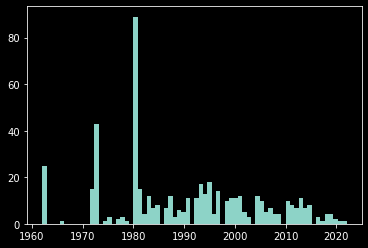

In [44]:
plt.figure()
start_years = df.groupby('ticker')['date'].apply(lambda x: x.dt.year.min())
plt.hist(start_years, bins=70)
plt.show()

# data reshape

- then find latest start date, and start there
- 90/10 split


## 1. filtering for tickers whose minimum year is at most `year_cutoff` 
- and then looking at data 1990 onwards
- Why: so each ticker have the same time range

In [247]:
df = year_filter_data(df, year_cutoff=1990)
print(len(df.ticker.unique()), 'tickers')

/var/folders/xc/7yy4pnhj7vs66gsxgymx9ffr0000gn/T/ipykernel_74246/963886275.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.ticker.isin(time_masks)][df.date.dt.year >= year_cutoff].reset_index(drop=True) # only look at data after year_cutoff


num time points: {8184}
257 tickers


In [249]:
len_train = 0.8
df_ix = df['ticker'].rename_axis('ix').reset_index()
df_ix.groupby('ticker').apply(lambda x: int(len_train*x.ix.max()))

ticker
AAPL    1558018
ABMD     575992
ABT       65471
ADBE     543256
ADI     1315772
         ...   
WY       739672
XEL      589087
XOM      497426
XRAY    1309224
ZION    1682415
Length: 257, dtype: int64

In [275]:
# https://stackoverflow.com/questions/55796153/train-test-split-based-on-a-column-values-sequentially
s = df.groupby('ticker').ticker.cumcount()#get the count for each group
s = s//(df.groupby('ticker').ticker.transform('count')*0.8).astype(int)
train = df.loc[s==0]
test = df.drop(train.index).reset_index(drop=True)
train = train.reset_index(drop=True)

In [280]:
s

0          0
1          0
2          0
3          0
4          0
          ..
2143902    1
2143903    1
2143904    1
2143905    1
2143906    1
Length: 2103288, dtype: int64

In [281]:
df.groupby('ticker').ticker.transform('count')*0.8

0          6547.2
1          6547.2
2          6547.2
3          6547.2
4          6547.2
            ...  
2143902    6547.2
2143903    6547.2
2143904    6547.2
2143905    6547.2
2143906    6547.2
Name: ticker, Length: 2103288, dtype: float64

In [279]:
train.groupby('ticker').apply(lambda x: )

ticker
AAPL     30256.790579
ABMD     88080.000036
ABT      93389.832592
ADBE    153013.388189
ADI     131161.430505
            ...      
WY       73045.508653
XEL      73716.468676
XOM     188655.982708
XRAY    128215.883049
ZION    171046.241120
Length: 257, dtype: float64

# Volatility
ewma, GARCH